In [12]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [13]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

In [ ]:
# train_transaction.head() # KEEP

In [ ]:
# train_identity.head() # KEEP

In [ ]:
# train_transaction.info(); # KEEP

In [ ]:
# train_identity.info(); # KEEP

#### Data Quality Check

In [23]:
# list_null = df_train.isnull().any() #KEEP
# df_null = pd.DataFrame(list_null).reset_index()
# df_null

In [24]:
# df_train.loc[:,df_train.isnull().any()]['id_34'].unique()

In [25]:
# # KEEP
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# print('Train feature columns:\n', list(columns))

In [26]:
# df_train.isnull().any() # KEEP

In [27]:
# df_train.info() # KEEP

In [28]:
# df_train.dtypes # KEEP

#### EDA

In [29]:
# How many transactions are in the dataset?
# df_train.shape # KEEP

In [30]:
# What is the fraud rate of the data set?
# fraud_rate = df_train.isFraud.value_counts() / 590540
# fraud_rate  # KEEP

In [31]:
# What is the statistical overview of the data set?
# df_train.describe() # KEEP

In [32]:
# fraud_summary = df_train.groupby('isFraud')
# fraud_summary.mean()

In [33]:
# fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_groupby.csv')

In [34]:
# df_train.isnull().any()

### Assigning columns to specific lists (cat, num, date, etc.)

In [15]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()

In [16]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

NameError: name 'pp' is not defined

In [19]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

In [542]:
##########################################

In [17]:
# What were the top TransactionAmt that were fraud? 
# What were the top TransactionAmt that were not fraud?
# Is fraud more likely to occur on debit or credit? 
# Does fraud happen in one address more than another? Look at the values counts for addr1 and isFraud

In [20]:
df_eda = df_raw.copy() # create df_eda

mode_card4 = df_eda.card4.mode()[0]
df_eda['card4'] = df_eda.card4.fillna(mode_card4)

mode_card6 = df_eda.card6.mode()[0]
df_eda['card6'] = df_eda.card6.fillna(mode_card6)

df_eda_not_fraud = df_eda[df_eda.isFraud==0]
df_eda_fraud = df_eda[df_eda.isFraud==1]

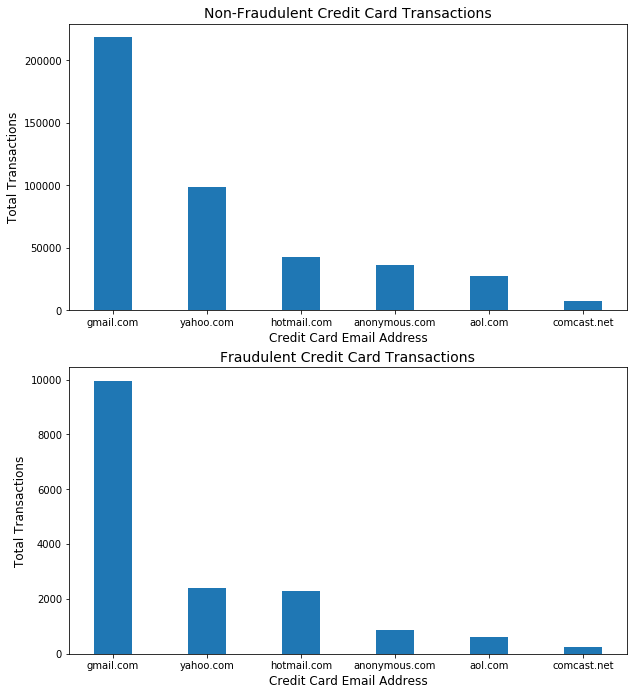

In [21]:
# top 10 most common email domains for credit card transactions
# COMPLETED
index_p_emaildomain= []
list_top_p_emaildomain = df_eda.P_emaildomain.value_counts().head(6).index
for val in list_top_p_emaildomain:
    index_temp = df_eda[df_eda.P_emaildomain==val].index.values
    index_p_emaildomain.append(index_temp)
index_final = [val for sublist in index_p_emaildomain for val in sublist]
df_p_emaildomain = df_eda.loc[index_final,:]

# creating dataframes for histogram
y_counts = df_p_emaildomain[df_p_emaildomain.isFraud==0].P_emaildomain.value_counts()
x_label = y_counts.index
y_counts_2 = df_p_emaildomain[df_p_emaildomain.isFraud==1].P_emaildomain.value_counts()
x_label_2 = y_counts.index

# creating plots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(top=1)

ax[0].set_title("Non-Fraudulent Credit Card Transactions", fontsize=14)
ax[0].set_ylabel('Total Transactions', fontsize=12)
ax[0].set_xlabel('Credit Card Email Address', fontsize=12)
ax[0].bar(x_label, y_counts, width=.4)

ax[1].set_title("Fraudulent Credit Card Transactions", fontsize=14)
ax[1].set_ylabel('Total Transactions', fontsize=12)
ax[1].set_xlabel('Credit Card Email Address', fontsize=12)
ax[1].bar(x_label_2, y_counts_2, width=.4)
plt.show()

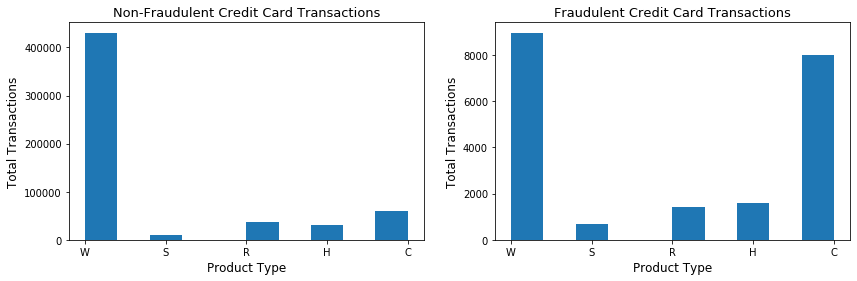

In [34]:
# EDA Product_CD
# COMPLETED
df_product_cd_notfraud = df_raw[df_raw.isFraud==0].ProductCD.sort_values(ascending=False)
df_product_cd_fraud = df_raw[df_raw.isFraud==1].ProductCD.sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].set_title("Non-Fraudulent Credit Card Transactions", fontsize=13)
ax[0].set_ylabel('Total Transactions', fontsize=12)
ax[0].set_xlabel('Product Type', fontsize=12)
ax[0].hist(df_product_cd_notfraud)
ax[1].set_title("Fraudulent Credit Card Transactions", fontsize=13)
ax[1].set_ylabel('Total Transactions', fontsize=12)
ax[1].set_xlabel('Product Type', fontsize=12)
ax[1].hist(df_product_cd_fraud)
plt.show()

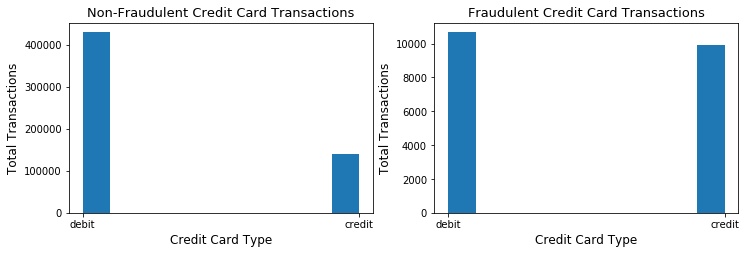

In [35]:
# EDA card6 - debit versus credit
# COMPLETED
df_card6_not_fraud = df_eda_not_fraud[(df_eda_not_fraud.card6=='credit') 
                                    | (df_eda_not_fraud.card6=='debit')]
df_card6_not_fraud = df_card6_not_fraud.card6.sort_values(ascending=False)
df_card6_fraud = df_eda_fraud.card6.sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(12,3.5))
ax[0].hist(df_card6_not_fraud)
ax[0].set_title("Non-Fraudulent Credit Card Transactions", fontsize=13)
ax[0].set_ylabel("Total Transactions", fontsize=12)
ax[0].set_xlabel("Credit Card Type", fontsize=12)
ax[1].hist(df_card6_fraud)
ax[1].set_title("Fraudulent Credit Card Transactions", fontsize=13)
ax[1].set_ylabel("Total Transactions", fontsize=12)
ax[1].set_xlabel("Credit Card Type", fontsize=12)
plt.show()

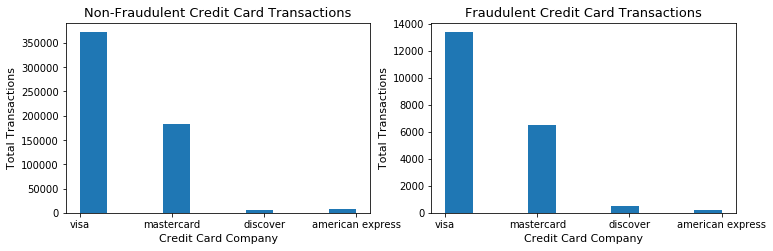

In [37]:
# EDA - card4 - credit card companies
# COMPLETED
fig, ax = plt.subplots(1, 2, figsize=(12,3.5))
ax[0].hist(df_eda_not_fraud.card4.sort_values(ascending=False))
ax[0].set_title("Non-Fraudulent Credit Card Transactions", fontsize=13)
ax[0].set_ylabel("Total Transactions", fontsize=12)
ax[0].set_xlabel("Credit Card Company", fontsize=12)

ax[1].hist(df_eda_fraud.card4.sort_values(ascending=False))
ax[1].set_title("Fraudulent Credit Card Transactions", fontsize=13)
ax[1].set_ylabel("Total Transactions", fontsize=12)
ax[1].set_xlabel("Credit Card Company", fontsize=12)
plt.show()

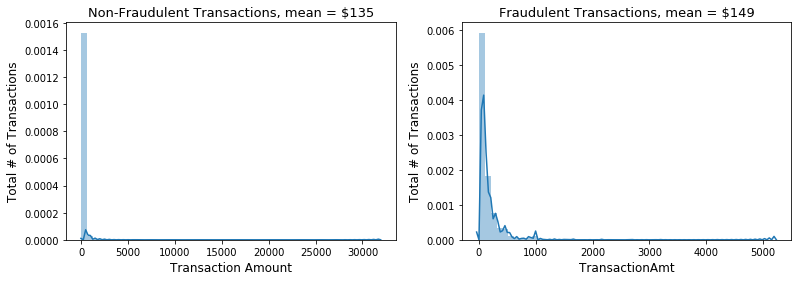

In [39]:
# EDA TransactionAmt
df_transactionamt_not_fraud = df_features[df_features.isFraud==0].TransactionAmt
df_transactionamt_fraud = df_features[df_features.isFraud==1].TransactionAmt
# print(df_transactionamt_not_fraud.mean())
# print(df_transactionamt_fraud.mean())

fig, ax = plt.subplots(1, 2, figsize=(13,4))
sns.distplot(df_transactionamt_not_fraud, ax=ax[0])
ax[0].set_title('Non-Fraudulent Transactions, mean = $135', fontsize=13)
ax[0].set_ylabel('Total # of Transactions', fontsize=12)
ax[0].set_xlabel('Transaction Amount', fontsize=12)
ax[1].set_title('Fraudulent Transactions, mean = $149', fontsize=13)
ax[1].set_ylabel('Total # of Transactions', fontsize=12)
ax[1].set_xlabel('Transaction Amount', fontsize=12)
sns.distplot(df_transactionamt_fraud, ax=ax[1])
plt.show()

In [ ]:
####################################

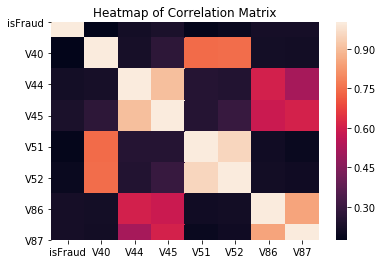

In [93]:
fraud_summary = df_features.groupby('isFraud')
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_summary.csv')

corr = df_features.corr()
corr.to_csv('/Users/krahman/work/fraud_detection/saved_files/corr_matrix.csv')
corr2 = corr[corr['isFraud']>.17]
corr2 = corr2.loc[:,corr2.index]

sns.heatmap(corr2,
           xticklabels=corr2.columns.values,
           yticklabels=corr2.columns.values)
plt.title('Heatmap of Correlation Matrix')
plt.show()

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Test Dropping Features On Base Model

In [ ]:
# ###DELETE

# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

# df_temp = pd.DataFrame(pca.explained_variance_ratio_)
# df_temp[0:20]
# pd.DataFrame(pca.components_, columns=list(X_temp.columns), index=range(0,225))
# pca.components_

### EDA

In [ ]:
# Hypothesis: less occurring email domains are more likely to have higher fraud_perc because they are 
# perhaps an email provider with less resources. The card that the holder has attached to certain email
# addresses puts them at higher risk for fraud. 

### Feature Engineering Class

In [ ]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000] ### delete
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('After running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000] ### delete
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat ### delete?
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('Dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        print("final dataframe created.")
        
    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        self._apply_pca(X, y)
        self._apply_downsampling() ###testing downsample
        self._apply_smote()

    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            X, y = self._drop_col_id_target(df_feat)
            X = self._pca(X)
            sm = SMOTE(random_state=42, n_jobs=-1)
            mod.X_features, mod.y_target = sm.fit_sample(X, y)
            print('tuning dataframe created.')
        else:
            print('bool_create_tuning_df set to false.')

    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X_pca = self._pca(X)
            self._split_dataframe(X_pca, y)
            print('PCA applied.')
        else:
            print("bool_apply_pca set to false.")
            self._split_dataframe(X, y)
            
    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(X, 
                                                                            y, 
                                                                            test_size=0.1, 
                                                                            random_state=42)
    def _apply_downsampling(self):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_mod_y_train_one = len(mod.y_train[mod.y_train==1])
            sampler = RandomUnderSampler(random_state=42, ratio={0:100000, 1:len_mod_y_train_one})
            mod.X_train, mod.y_train = sampler.fit_sample(mod.X_train, 
                                                          mod.y_train)
            print("downsampling applied.")
        else:
            print("bool_apply_downsampling set to false.")
            
    def _apply_smote(self):
        '''applying smote to split training set'''
        if bool_apply_smote:
            sm = SMOTE(random_state=42, n_jobs=-1)
            mod.X_train, mod.y_train = sm.fit_sample(mod.X_train, 
                                                     mod.y_train)
            print("smote applied.")
        else:
            print("bool_apply_smote set to false.")
        
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("Keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat

fe = FeatureEngineering()

bool_apply_pca = True
bool_apply_smote = True
bool_apply_downsampling = True
bool_create_tuning_df = True
bool_drop_col = True

df_feat_1000 = False
# fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
#                                             'card6', 'V294','V279','C14','V306','D2','D10'])
# bool_drop_col = False
# fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
# fe.list_drop_col.append('C4')
# fe.create_final_df()

fe.feature_testing(bool_drop_col, list_feat=['addr1'])

While running feature_testing, do not run final_features.
PCA applied.
downsampling applied.
smote applied.
Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [55]:
print(y_target_test.shape)
print(df_features_test.shape)
y_target_test = df_features.isFraud
df_features_test = df_features.drop('isFraud', axis=1)

(590540,)
(590540, 284)


In [69]:
sampler = RandomUnderSampler(random_state=42, ratio={0:100000, 1:20663})
df_features_res, y_target_res = sampler.fit_sample(df_features_test, y_target_test)

sm = SMOTE(random_state=42, n_jobs=-1)
df_features_res, y_target_res = sm.fit_sample(df_features_res, y_target_res)

mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(df_features_res, 
                                                                    y_target_res,
                                                                    test_size=0.1, 
                                                                    random_state=42)

model_lr_temp = LogisticRegression(random_state=42, n_jobs=1)
model_lr_temp.fit(mod.X_train, mod.y_train)
pred_lr = model_lr_temp.predict(mod.X_test)
print(confusion_matrix(mod.y_test, pred_lr))
print(roc_auc_score(mod.y_test, pred_lr))
# NEXT, make sure to save the undersample file below... 

[[6794 3167]
 [3021 7018]]
0.6905668235213857


In [75]:
len(mod.y_train[mod.y_train==1])

18554

In [ ]:
#####

In [ ]:
# we need to add delete functions to our created dataframes potentially..
mod.X_features = pd.DataFrame(mod.X_features)
mod.y_target = pd.DataFrame(mod.y_target)

mod.X_features.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')

In [37]:
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')
mod.X_features = mod.X_features.drop('Unnamed: 0', axis=1)
mod.y_target = mod.y_target.drop('Unnamed: 0', axis=1)

In [39]:
mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features, 
                                                                    mod.y_target, 
                                                                    test_size=0.1, 
                                                                    random_state=42)

In [238]:
# mod.X_features.info(memory_usage='deep')
# mod.y_target.info(memory_usage='deep')

In [7]:
# bool_predict_proba = False
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current)


In [ ]:
# model_current = DecisionTreeClassifier(random_state=42)
# mod.create_df_score_model(model_current)


In [8]:
# bool_predict_proba = False
# model_current = RandomForestClassifier(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [40]:
# bool_predict_proba = False
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current) 


In [22]:
class Model():
    def __init__(self, bool_smote):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        
    def create_df_score_model(self, model_current):
        '''scores model'''
        print("Fitting model:\n", model_current)
        y_pred, elapsed_time = self.add_model(model_current) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, 
                                                       elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model_current)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred = self._predict(model)
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred = self._predict_proba(model)
            return y_pred 
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            y_pred_class = self._predict_proba_threshold(y_pred_prob)
            return y_pred_class
        except:
            print("Model does not have predict_proba attribute.")
            
    def _predict_proba_threshold(self, y_pred_prob):
        for threshold in [.1, .15, .2, .25, .3, .35, .4, .45, .5]:
            print('threshold: ', threshold)
            y_pred_class = binarize(y_pred_prob, threshold)[:,1]
            print('roc auc score:', roc_auc_score(mod.y_test, y_pred_class))
            print('confusion matrix:\n', confusion_matrix(mod.y_test, y_pred_class))
        return y_pred_class
            
#     def _create_roc_curve(self, y_pred_class):
#         fpr, tpr, thresholds = roc_curve(mod.y_test, y_pred_class)
#         plt.plot(fpr, tpr)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.title("ROC curve for classifier")
#         plt.xlabel("False Positive Rate (1 - Specificity)")
#         plt.ylabel("True Positive Rate (Sensitivity)")
#         plt.grid(True)
#         plt.show()
        
    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time = self._calc_scores(y_pred, 
                                                                  elapsed_time)        
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print("roc score:", roc_auc_score(mod.y_test, y_pred))
        return col_recall, col_precision, col_time
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\nPrinting df_scores...\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            df_feat_rank = self._feat_import_create_df(model)
            self._feat_import_create_plot(df_feat_rank)
            print(df_feat_rank[0:10].reset_index(drop=True))
        except:
            print("\nmodel does not have _feature_importance attribute.")
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(fe.df_feat.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        
mod = Model(bool_smote=True)

In [106]:
model_xgbc = XGBClassifier()
model_xgbc.fit(mod.X_train, mod.y_train)
y_pred_xgbc = model_xgbc.predict(mod.X_test)
print(classification_report(mod.y_test, y_pred_xgbc))
print(confusion_matrix(mod.y_test, y_pred_xgbc))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     56954
           1       0.84      0.77      0.80     57022

    accuracy                           0.81    113976
   macro avg       0.81      0.81      0.81    113976
weighted avg       0.81      0.81      0.81    113976

[[48297  8657]
 [12938 44084]]


In [107]:
model_cbc = CatBoostClassifier()
X_test
model_cbc.fit(mod.X_train, mod.y_train)
# y_pred_cbc = model_cbc.predict(mod.y_test)
# print(classification_report(mod.y_test, y_pred_cbc))
# print(confusion_matrix(mod.y_test, y_pred_cbc))

test_data = Pool(mod.X_test)
y_pred_cbc = model_cbc.predict(test_data)
print(classification_report(mod.y_test, y_pred_cbc))
print(confusion_matrix(mod.y_test, y_pred_cbc))


Learning rate set to 0.198909
0:	learn: 0.6240264	total: 1.1s	remaining: 18m 18s
1:	learn: 0.5785624	total: 2.08s	remaining: 17m 18s
2:	learn: 0.5475567	total: 2.75s	remaining: 15m 14s
3:	learn: 0.5277911	total: 3.54s	remaining: 14m 41s
4:	learn: 0.5121049	total: 4.24s	remaining: 14m 3s
5:	learn: 0.5015644	total: 4.88s	remaining: 13m 27s
6:	learn: 0.4919728	total: 5.62s	remaining: 13m 17s
7:	learn: 0.4842326	total: 6.26s	remaining: 12m 56s
8:	learn: 0.4782616	total: 6.78s	remaining: 12m 26s
9:	learn: 0.4733810	total: 7.48s	remaining: 12m 20s
10:	learn: 0.4684484	total: 8.22s	remaining: 12m 18s
11:	learn: 0.4646191	total: 8.84s	remaining: 12m 7s
12:	learn: 0.4608227	total: 9.76s	remaining: 12m 20s
13:	learn: 0.4573635	total: 10.4s	remaining: 12m 12s
14:	learn: 0.4540123	total: 11s	remaining: 12m 4s
15:	learn: 0.4506656	total: 11.6s	remaining: 11m 52s
16:	learn: 0.4478832	total: 12.2s	remaining: 11m 46s
17:	learn: 0.4453750	total: 12.9s	remaining: 11m 43s
18:	learn: 0.4422564	total: 13.5

154:	learn: 0.3165626	total: 1m 49s	remaining: 9m 55s
155:	learn: 0.3161005	total: 1m 49s	remaining: 9m 54s
156:	learn: 0.3155433	total: 1m 51s	remaining: 9m 56s
157:	learn: 0.3150885	total: 1m 51s	remaining: 9m 55s
158:	learn: 0.3146775	total: 1m 52s	remaining: 9m 54s
159:	learn: 0.3142292	total: 1m 53s	remaining: 9m 53s
160:	learn: 0.3136981	total: 1m 53s	remaining: 9m 52s
161:	learn: 0.3132206	total: 1m 54s	remaining: 9m 52s
162:	learn: 0.3127837	total: 1m 54s	remaining: 9m 50s
163:	learn: 0.3123158	total: 1m 55s	remaining: 9m 49s
164:	learn: 0.3117870	total: 1m 56s	remaining: 9m 49s
165:	learn: 0.3112792	total: 1m 57s	remaining: 9m 49s
166:	learn: 0.3108244	total: 1m 58s	remaining: 9m 49s
167:	learn: 0.3103500	total: 1m 58s	remaining: 9m 47s
168:	learn: 0.3098775	total: 1m 59s	remaining: 9m 47s
169:	learn: 0.3093914	total: 2m	remaining: 9m 46s
170:	learn: 0.3090063	total: 2m	remaining: 9m 45s
171:	learn: 0.3085290	total: 2m 1s	remaining: 9m 45s
172:	learn: 0.3080603	total: 2m 2s	re

308:	learn: 0.2589044	total: 3m 41s	remaining: 8m 15s
309:	learn: 0.2586027	total: 3m 42s	remaining: 8m 15s
310:	learn: 0.2583125	total: 3m 43s	remaining: 8m 14s
311:	learn: 0.2580445	total: 3m 43s	remaining: 8m 13s
312:	learn: 0.2577628	total: 3m 44s	remaining: 8m 12s
313:	learn: 0.2575431	total: 3m 44s	remaining: 8m 11s
314:	learn: 0.2572918	total: 3m 45s	remaining: 8m 10s
315:	learn: 0.2569802	total: 3m 46s	remaining: 8m 9s
316:	learn: 0.2567218	total: 3m 46s	remaining: 8m 8s
317:	learn: 0.2564669	total: 3m 47s	remaining: 8m 7s
318:	learn: 0.2561751	total: 3m 48s	remaining: 8m 7s
319:	learn: 0.2558941	total: 3m 48s	remaining: 8m 6s
320:	learn: 0.2556134	total: 3m 49s	remaining: 8m 5s
321:	learn: 0.2553599	total: 3m 50s	remaining: 8m 4s
322:	learn: 0.2551408	total: 3m 50s	remaining: 8m 3s
323:	learn: 0.2548954	total: 3m 51s	remaining: 8m 3s
324:	learn: 0.2546513	total: 3m 52s	remaining: 8m 2s
325:	learn: 0.2543942	total: 3m 53s	remaining: 8m 1s
326:	learn: 0.2541131	total: 3m 53s	rem

461:	learn: 0.2228128	total: 5m 31s	remaining: 6m 25s
462:	learn: 0.2225371	total: 5m 31s	remaining: 6m 24s
463:	learn: 0.2223309	total: 5m 32s	remaining: 6m 24s
464:	learn: 0.2221197	total: 5m 33s	remaining: 6m 23s
465:	learn: 0.2219227	total: 5m 33s	remaining: 6m 22s
466:	learn: 0.2217749	total: 5m 34s	remaining: 6m 21s
467:	learn: 0.2215814	total: 5m 35s	remaining: 6m 21s
468:	learn: 0.2214051	total: 5m 35s	remaining: 6m 20s
469:	learn: 0.2212052	total: 5m 36s	remaining: 6m 19s
470:	learn: 0.2209822	total: 5m 37s	remaining: 6m 18s
471:	learn: 0.2207653	total: 5m 37s	remaining: 6m 18s
472:	learn: 0.2206335	total: 5m 38s	remaining: 6m 17s
473:	learn: 0.2204375	total: 5m 39s	remaining: 6m 16s
474:	learn: 0.2202698	total: 5m 39s	remaining: 6m 15s
475:	learn: 0.2200863	total: 5m 40s	remaining: 6m 14s
476:	learn: 0.2198787	total: 5m 41s	remaining: 6m 13s
477:	learn: 0.2196960	total: 5m 41s	remaining: 6m 13s
478:	learn: 0.2194680	total: 5m 42s	remaining: 6m 12s
479:	learn: 0.2192981	total:

614:	learn: 0.1961115	total: 7m 18s	remaining: 4m 34s
615:	learn: 0.1959803	total: 7m 19s	remaining: 4m 33s
616:	learn: 0.1958331	total: 7m 20s	remaining: 4m 33s
617:	learn: 0.1956978	total: 7m 27s	remaining: 4m 36s
618:	learn: 0.1955797	total: 7m 28s	remaining: 4m 36s
619:	learn: 0.1954443	total: 7m 29s	remaining: 4m 35s
620:	learn: 0.1952918	total: 7m 29s	remaining: 4m 34s
621:	learn: 0.1951429	total: 7m 30s	remaining: 4m 33s
622:	learn: 0.1949961	total: 7m 31s	remaining: 4m 33s
623:	learn: 0.1948618	total: 7m 31s	remaining: 4m 32s
624:	learn: 0.1946611	total: 7m 32s	remaining: 4m 31s
625:	learn: 0.1945045	total: 7m 33s	remaining: 4m 30s
626:	learn: 0.1943604	total: 7m 33s	remaining: 4m 30s
627:	learn: 0.1942207	total: 7m 34s	remaining: 4m 29s
628:	learn: 0.1940644	total: 7m 35s	remaining: 4m 28s
629:	learn: 0.1938979	total: 7m 36s	remaining: 4m 27s
630:	learn: 0.1937629	total: 7m 36s	remaining: 4m 27s
631:	learn: 0.1935984	total: 7m 37s	remaining: 4m 26s
632:	learn: 0.1934689	total:

767:	learn: 0.1757888	total: 9m 30s	remaining: 2m 52s
768:	learn: 0.1756191	total: 9m 31s	remaining: 2m 51s
769:	learn: 0.1754950	total: 9m 32s	remaining: 2m 50s
770:	learn: 0.1753681	total: 9m 33s	remaining: 2m 50s
771:	learn: 0.1752400	total: 9m 33s	remaining: 2m 49s
772:	learn: 0.1751395	total: 9m 34s	remaining: 2m 48s
773:	learn: 0.1750278	total: 9m 35s	remaining: 2m 48s
774:	learn: 0.1749014	total: 9m 36s	remaining: 2m 47s
775:	learn: 0.1747698	total: 9m 37s	remaining: 2m 46s
776:	learn: 0.1746542	total: 9m 38s	remaining: 2m 45s
777:	learn: 0.1745387	total: 9m 38s	remaining: 2m 45s
778:	learn: 0.1744282	total: 9m 39s	remaining: 2m 44s
779:	learn: 0.1743161	total: 9m 40s	remaining: 2m 43s
780:	learn: 0.1742073	total: 9m 40s	remaining: 2m 42s
781:	learn: 0.1741025	total: 9m 41s	remaining: 2m 42s
782:	learn: 0.1739843	total: 9m 42s	remaining: 2m 41s
783:	learn: 0.1738930	total: 9m 42s	remaining: 2m 40s
784:	learn: 0.1737848	total: 9m 43s	remaining: 2m 39s
785:	learn: 0.1736881	total:

918:	learn: 0.1592320	total: 11m 25s	remaining: 1m
919:	learn: 0.1591227	total: 11m 26s	remaining: 59.7s
920:	learn: 0.1590127	total: 11m 27s	remaining: 58.9s
921:	learn: 0.1588992	total: 11m 27s	remaining: 58.2s
922:	learn: 0.1588196	total: 11m 28s	remaining: 57.4s
923:	learn: 0.1587307	total: 11m 29s	remaining: 56.7s
924:	learn: 0.1586378	total: 11m 29s	remaining: 55.9s
925:	learn: 0.1585330	total: 11m 30s	remaining: 55.2s
926:	learn: 0.1584300	total: 11m 31s	remaining: 54.5s
927:	learn: 0.1583504	total: 11m 32s	remaining: 53.7s
928:	learn: 0.1582575	total: 11m 32s	remaining: 53s
929:	learn: 0.1581672	total: 11m 33s	remaining: 52.2s
930:	learn: 0.1580856	total: 11m 34s	remaining: 51.4s
931:	learn: 0.1579751	total: 11m 35s	remaining: 50.7s
932:	learn: 0.1578682	total: 11m 35s	remaining: 50s
933:	learn: 0.1577755	total: 11m 36s	remaining: 49.2s
934:	learn: 0.1576780	total: 11m 37s	remaining: 48.5s
935:	learn: 0.1575591	total: 11m 37s	remaining: 47.7s
936:	learn: 0.1574579	total: 11m 38

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:228: Feature 1 is present in model but not in pool.

In [118]:
test_data = Pool(mod.X_test)
y_pred_cbc = model_cbc.predict(test_data)
print(classification_report(mod.y_test, y_pred_cbc))
print(confusion_matrix(mod.y_test, y_pred_cbc))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     56954
           1       0.95      0.95      0.95     57022

    accuracy                           0.95    113976
   macro avg       0.95      0.95      0.95    113976
weighted avg       0.95      0.95      0.95    113976

[[53839  3115]
 [ 2983 54039]]


In [162]:
print(df_features[df_features.isFraud==0].shape)
print(df_features[df_features.isFraud==1].shape)

(569877, 285)
(20663, 285)


179337

In [236]:
# X_train, X_test, y_train, y_test = train_test_split(X_feat, 
#                                                     y_target, 
#                                                     test_size=0.1, 
#                                                     random_state=42)

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, 
                                                                y_rs, 
                                                                test_size=0.1, 
                                                                random_state=42)

In [237]:
# base model
model_lr_temp = LogisticRegression(random_state=42, n_jobs=-1)
model_lr_temp.fit(mod.X_train, mod.y_train)
pred_lr = model_lr_temp.predict(mod.X_test)
print(confusion_matrix(mod.y_test, pred_lr))
print(roc_auc_score(mod.y_test, pred_lr))
# NEXT, we fixed our downsample and upsamp

[[48301  8653]
 [13502 43520]]
0.8056422853051062


In [234]:
# under and up sample
model_lr_temp.fit(X_train_rs, y_train_rs)
pred_lr = model_lr_temp.predict(X_test_rs)
print(confusion_matrix(y_test_rs, pred_lr))
print(roc_auc_score(y_test_rs, pred_lr))
# NEXT, look at our base model score.. then determine how we can apply pca, etc. then
# test with our new feature, or raw dataframe.. we need to test with our raw dataframe,
# then add addr1 feature, then test with pca, etc. potentially smote too. check to
# see how we got the 360 fp score

[[6794 3167]
 [3021 7018]]
0.6905668235213857


In [239]:
model_lr_temp.fit(mod.X_train, mod.y_train)
pred_lr = model_lr_temp.predict(mod.X_test)
print(confusion_matrix(mod.y_test, pred_lr))
print(roc_auc_score(mod.y_test, pred_lr))

[[48301  8653]
 [13502 43520]]
0.8056422853051062


## Model Tuning

#### RFC Tuning

#### Manual Tuning - XGBClassifier

In [ ]:
##############################

In [155]:
# mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features[0:10000], 
#                                                                     mod.y_target[0:10000], 
#                                                                     test_size=0.1, 
#                                                                     random_state=42)
mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features, 
                                                                    mod.y_target, 
                                                                    test_size=0.1, 
                                                                    random_state=42)

In [141]:
# testing deleting
# # start_time = time.time()
# # model.fit(mod.X_train, mod.y_train)
# # y_pred = self._predict(model)
# # elapsed_time = (time.time() - start_time) / 60
# list_time_elapsed = []
# list_roc_score = []
# start_time = time.time()
# model_xgbc = XGBClassifier(max_depth=1, n_jobs=-1, random_state=42)
# model_xgbc.fit(mod.X_train, mod.y_train)
# y_pred_xgbc = model_xgbc.predict(mod.X_test)
# elapsed_time = (time.time() - start_time) / 60
# score_roc = roc_auc_score(mod.y_test, y_pred_xgbc)
# confusion_matrix(mod.y_test, y_pred_xgbc)
# # score_roc

array([[974,   0],
       [ 26,   0]])

In [156]:
### manual xbgc tuning
max_depth = [3,5,7,9,11,13]
max_depth = [1,3,5]
list_time_elapsed = []
list_roc_auc_score = []
for val in max_depth:
    model_xgbc = XGBClassifier(max_depth=val, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    model_xgbc.fit(mod.X_train, mod.y_train)
    y_pred_xgbc = model_xgbc.predict(mod.X_test)
    elapsed_time = (time.time() - start_time) / 60
    
    score_roc_auc = roc_auc_score(mod.y_test, y_pred_xgbc)
    print(score_roc_auc) #delete
    list_time_elapsed.append(elapsed_time)
    list_roc_auc_score.append(score_roc_auc)
    print('max depth: ', val)
    print(confusion_matrix(mod.y_test, y_pred_xgbc))

0.7706408401224432
0.8105526288936864
0.8487235403851862


In [157]:
col_time_elapsed = pd.Series(list_time_elapsed)
col_roc_score = pd.Series(list_roc_auc_score)
col_max_depth = pd.Series(max_depth)
df_results_xgbc = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
                            keys=['max_depth', 'roc_auc_score', 'time_elap'], 
                            axis=1)
df_results_xgbc

,max_depth,roc_auc_score,time_elap
0,1,0.770641,106.619137
1,3,0.810553,42.508644
2,5,0.848724,68.404212


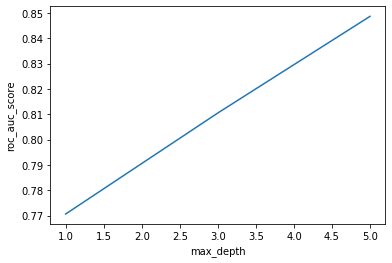

In [158]:
sns.lineplot(x='max_depth', y='roc_auc_score', data=df_results_xgbc)
plt.title("XGBC manual tuning")
plt.show()

# NEXT, we need to test under sampling the data... then test model performance on 
# our base model logistic regression.... 

In [ ]:
##############################

In [ ]:
### Tuning XGBClassifier READY ###
print('tuning xgbc')
xgbc = XGBClassifier(n_jobs=-1, random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [1,3,5,7]
# colsample_bytree = [1,3,5,7]
# colsample_bylevel = [0,.1,.3,.5,.7,.9,1]
# colsample_bynode = [1,3,5,7]
# reg_alpha = [0,1,3,5,7]
# reg_lambda = [1,3,5,7]
# scale_pos_weight = [1,3,5,7]
# base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, learning_rate=learning_rate, booster=booster, 
                       subsample=subsample, 
#                        colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, 
#                        colsample_bynode=colsample_bynode, reg_alpha=reg_alpha, reg_lambda=reg_lambda, 
#                        scale_pos_weight=scale_pos_weight,
#                        base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
# print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
# print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
# print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
# print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
# print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
# print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
# print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])



tuning xgbc
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [9]:
#### Tuning RandomForestClassifier READY ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=-1, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

# n_estimators = [50,75,100,125]
# criterion = ['gini']
# max_depth = [2,3,4,5,6,7,None]
# min_samples_split = [6,7,8,9]
# min_samples_leaf = [1,2]
# min_weight_fraction_leaf = [0]
# max_features = ['auto', 'sqrt', 'log2', None]
# max_leaf_nodes = [None]
# min_impurity_decrease = [0]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=7, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])


In [60]:
#### LR Tuning ####
lr = LogisticRegression(n_jobs=3, random_state=42, verbose=1)

penalty = ['l1', 'l2', 'elasticnet', 'none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, tol=tol, C=C, 
                       fit_intercept=fit_intercept,
                       intercept_scaling=intercept_scaling, class_weight=class_weight,
                       solver=solver, max_iter=max_iter,
                       multi_class=multi_class, l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=5, verbose=10, n_jobs=3, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [61]:
#### Tuning DTC READY ####
dt = DecisionTreeClassifier(random_state=42)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=3, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [483]:
### Tuning CatBoost READY ###
# Tune learning rate manually.
cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
# learning_rate = [.1,.3,.5,.7,.9]
# bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]
# depth = [2,4,6,8,10]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']


hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       n_estimators=n_estimators,
                       subsample=subsample,
#                        depth=depth,
                       grow_policy=grow_policy
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=5, verbose=10, n_jobs=-1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/krahman/opt/anaconda3/lib/python3.7/pickle.py", line 549, in save
    self.save_reduce(obj=obj,

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 13.5min


CatBoostError: catboost/private/libs/options/bootstrap_options.cpp:5: Taken fraction should in in (0,1]

In [21]:
# cbc.fit(x)
mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features, 
                                                                    mod.y_target, 
                                                                    test_size=0.1, 
                                                                    random_state=42)

In [108]:
# cbc.fit(mod.X_train, mod.y_train)

In [ ]:
pred_cbc = cbc.predict(mod.X_test)
confusion_matrix(y_test, pred_cbc)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
roc score: 0.7653269954567143
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56945
           1       0.57      0.55      0.56      2109

    accuracy                           0.97     59054
   macro avg       0.78      0.77      0.77     59054
weighted avg       0.97      0.97      0.97     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
333     addr1_fe  682.0  19343.0   0.06

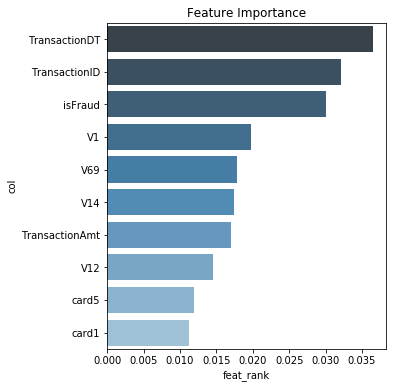

              col  feat_rank
0   TransactionDT   0.036505
1   TransactionID   0.032122
2         isFraud   0.030023
3              V1   0.019718
4             V69   0.017775
5             V14   0.017476
6  TransactionAmt   0.016972
7             V12   0.014583
8           card5   0.011881
9           card1   0.011186
Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
roc score: 0.7653269954567143
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56945
           1       0.57      0.55      0

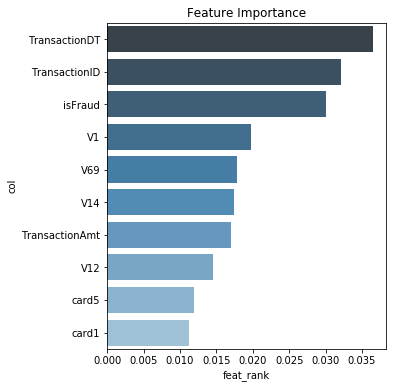

              col  feat_rank
0   TransactionDT   0.036505
1   TransactionID   0.032122
2         isFraud   0.030023
3              V1   0.019718
4             V69   0.017775
5             V14   0.017476
6  TransactionAmt   0.016972
7             V12   0.014583
8           card5   0.011881
9           card1   0.011186


In [143]:
# bool_predict_proba = False
# # tuned model
# current_model = RandomForestClassifier(
#                        max_depth=3, max_features='log2',
#                        min_impurity_decrease=0.0, 
#                        min_samples_leaf=1, min_samples_split=7,
#                        min_weight_fraction_leaf=0.0, n_estimators=50,
#                        n_jobs=-1, oob_score=False, random_state=42,
#                        verbose=0, warm_start=False)
# mod.create_df_score_model(model_current)

# # base model
# current_model = RandomForestClassifier(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [ ]:
# model.create_df_score_model(df_feat)
# 369.0 all col
# 398.0 remove P_emaildomain
# 410.0 remove card6
# 395.0 drop C4
# 415.0 add all back in
# 368.0 test again with C14


In [ ]:
# create feature from TransactionAmt. Add more EDA information. 



In [ ]:
# 1. Model Tuning
# 2. Finished - Features
# 3. more EDA
# 4. Finished - move pca and smote into fe. 

In [ ]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read[len(df_temp_read)-40:]

In [ ]:
# # it reads the csv, creates a dataframe, then appends the results, then saves over the old version and keeps
# # a record of all columns in the tested dataframe.

# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# # we want to test a feature for feature engineering... we must 

# for col_original, col_new in zip(list_col, fe.list_new_feat):
#     print(col_original, col_new)
#     X[col_new] = fe.df_feat[col_new]
#     X = X.drop(col_original, axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()

#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
    
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
    
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
# #     X = X.drop(col, axis=1)
#     print(list(X.columns))

In [ ]:
# fe.df_feat['time_delta'] = df_temp['time_delta']
# fe.df_feat['time_delta_week'] = df_temp['time_delta']/7
# fe.df_feat['time_delta_month'] = df_temp['time_delta']/30
# fe.df_feat

In [ ]:
##### implement into feature engineering class. days lapsed
df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta
    
    

In [ ]:
# KEEP
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


In [ ]:
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# plt.hist(y_pred_prob[:,1], bins=8)
# plt.xlim(0,1)
# plt.title("Histogram of Probability of Fraud")
# plt.xlabel("Predicted probability of Fraud")
# plt.ylabel("Frequency")

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
e

# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

# fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title("ROC curve for fraud detection classifier")
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.grid(True)
# plt.show()

In [ ]:
# def evaluate_threshold(threshold):
#     print("Sensitivity:", tpr[thresholds > threshold][-1])
#     print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')
    
# evaluate_threshold(.5)
# evaluate_threshold(.2)
# evaluate_threshold(.1)

# print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
# print('y_pred_actual on test set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y_test2, y_pred_actual))
# print(classification_report(y_test2, y_pred_actual))

# print('y_pred_proba\n')
# y_pred_proba = model_lr_pca.predict_proba(X_test2)
# y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y_test2, y_pred_class))
# print(classification_report(y_test2, y_pred_class))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
# print('Logistic Regression')
# print('y_pred_actual full data set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y, y_pred_actual))
# print(classification_report(y, y_pred_actual))

# print('y_pred_proba full data set\n')
# y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
# y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

In [ ]:
# sns.barplot(x='TransactionDT', y='TransactionDT', hue='isFraud', data=df_features)
# plt.title("Transaction Date Versus Fraud")
# plt.show()

# we want to figure out how to create more features from TransactionDT.. 
# are certain transactions more likely. in general, to be fraudualant around a certain day? 
# we have transactionID yet we dont have the specific card of who it belongs to.. 
# if card1 is the unique identifier... and we did a groupby on fraud.. 
# we have average spent per day as an option... 
# create a feature that is average spent per day for non fraud versus average spent per day for fraud.. 
# what would the describe method reveal for us? 